In [23]:
import scipy.constants as const
from arc import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.optimize import fmin
from scipy.optimize import brentq
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (25.0, 8.0)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['grid.alpha'] = 0.15
mpl.rcParams['axes.formatter.limits'] = (-3,3)
mpl.rcParams['image.cmap'] = 'viridis'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 22}
mpl.rc('font', **font)
plt.rcParams["axes.linewidth"] = 1.5
color1 = 'tab:green'
color2 = 'tab:blue'
markersize = 10
capsize = 5

# Light assisted two body loss rate

In [2]:
def trap_depth_gaussian(pol, P, wx, wy):
    """ trap depth for a focused gaussian beam
        pol: polarizability in units of Hz m^2/W
        P: power of the beam (W)
        wx: waist along x direction in m
        wy: waist along y direction in m
        return trap depth in Hz
    """
    I0_elliptical_xy= 2*P/ (np.pi* wx * wy) #multiply waists from um to cm such 
    U0_xy = - pol * I0_elliptical_xy/4 #in Hz. Divide by 4 because we used peak electric field in the calculation
                                    #of polarizability instead of rms.
    return U0_xy

### Sanity check: Tweezer
1.7 mW of 852nm focused on a round waist of 0.75 um, should yieald 1 mK trap depth

In [3]:
mass_Rb = 87*const.u
atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)

alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(852e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarization of GS with 852nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.76e-3, 0.707e-6, 0.707e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)

Polarization of GS with 852nm = 3.884e-02 Hz m^2/W.
Trap depth in uK:  -1044.518430852995


In [4]:
mass_Rb = 87*const.u
def trap_volume(T0, omega_ax, omega_rad, mass=mass_Rb):
    """
    T0 initial temperature in K
    omega_ax (rad) axial (radial) trap fequencies
    return in m^3
    """
    omega = (omega_ax * omega_rad**2)**(1/3)
    return (2*np.pi*const.k*T0/ (mass* omega**2))**(3/2)

def calc_beta(gamma,V):
    """
    gamma is the fitted two-body loss decay rate. 
    V trap volume
    return in SI units m^3/s
    """
    return gamma * 2* np.sqrt(2) * V

## Monte-Carlo simulation

To find $\beta^{\prime}$, we need to compute the infintesimal probabilities for two-body and one-body loss events between times $t$ and $t + dt$, and fit the resulting probabilites to the data. 

$d q_{\text {two-body }}=\beta^{\prime} N(t)[N(t)-1] d t / 2$ 

$d q_{\text {one-body }}=\gamma(t) N(t) d t$

$\gamma(t) = - \dot P_1(t)/P_1(t)$ is the one-body loss rate, where $P_1(t)$ is the probability that a single atom remains in the trap:

$P_1(t)=1-\left(1+\eta(t)+\frac{1}{2} \eta(t)^2\right) \exp (-\eta(t))$  (assuming a harmonic trap and a Boltzmann energy distribution) 

Here, $ \eta(t) = \frac{U}{T_0+\alpha}$ where $T_0$ is the initial atom temperaturem and $\alpha$ is is the single-atom heating rate 

In [5]:
def dq_two_body(beta_prime, N, dt):
    return beta_prime * N*(N-1)*dt/2

def dq_one_body(gamma, N, dt):
    return gamma * N *dt

def P1(t,U, T0, alpha):
    """ Survival probability of an atom due to heating. Assuming a harmonic trap and a Boltzmann energy distribution
    U: trap depth in J
    T0 initial temperature
    alpha: heating rate"""
    return 1- np.exp(- U/(T0 + alpha*t) ) * ( 1+ U/(T0 + alpha*t) + U**2/(2*(T0 + alpha*t)**2) )

def gamma(t,U, T0, alpha):
    P1 = 1- np.exp(- U/(T0 + alpha*t) ) * ( 1+ U/(T0 + alpha*t) + U**2/(2*(T0 + alpha*t)**2) )
    P1_dot = np.gradient(P1,t)
    t_value = .03  # Replace with your desired t value
    P1_dot = -U * alpha * np.exp(-U / (T0 + alpha * t)) / ((T0 + alpha * t) ** 2)
    return float(P1_dot/P1*-1  )

def number_of_lost_atoms(key_name):
    if key_name == 'no_loss':
            return 0 # no loss
    elif key_name== 'one_loss':
            return 1 # one loss
    elif key_name== 'two_loss':
            return 2 # two loss

## Define beta' function

In [6]:
def betaPrimeFit(ts, beta_prime,alpha, U=1e-3,T0=30e-6):
    trajectories = 500
    dt_step = ts[1] - ts[0]
    surv_sum_traj = np.zeros(len(ts))

    for j in np.arange(trajectories):
        surv_dts = np.zeros(len(ts)) 
        surv_dts[0] = 2    # Initial number of atoms = 2
        for i in range(len(ts)):
            # print("\033[1m trajectory # \033[0m",j,"\033[1m time step # \033[0m",i)
            if i == 0:
                num_atoms_at_this_step = surv_dts[0]  # fixes inital atom number at N=2
            else:
                num_atoms_at_this_step = surv_dts[i - 1] # selects matrix elemenet
            P_two_body_loss = dq_two_body(beta_prime, num_atoms_at_this_step, dt_step)
            P_one_body_loss = dq_one_body(gamma(dt_step,U,T0,alpha), num_atoms_at_this_step, dt_step)
            prob_no_loss = (1 - P_one_body_loss) * (1 - P_two_body_loss)
            prob_one_loss = P_one_body_loss * (1 - P_two_body_loss)
            prob_two_loss = (1 - P_one_body_loss) * P_two_body_loss

            prob_dict = {'no_loss': prob_no_loss, 'one_loss': prob_one_loss, 'two_loss': prob_two_loss}
            
            # Define a probability order (smallest prob to largest prob)
            ordered_dict = sorted(prob_dict.items(), key=lambda x: x[1]) 
            
            # Choose which decay channel will happen using Monte Carlo
            p_rand = random.random() # random number between 0 and 1
            p_rand_20_21 = random.random()
            # print('p_rand=',p_rand)
            # print('probabilites=',ordered_dict)
            if p_rand < ordered_dict[0][1]: # if random number is less than the smallest loss probability of the three loss options
                if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                    surv_dts[i] -= 1
                else: 
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[0][0]) # then the # of remaining atoms at this time step is determined by key name of smallest survival probability
                # print('key, atoms lost=',ordered_dict[0][0],',',number_of_lost_atoms(ordered_dict[0][0]))
                # print('remaining atoms at this time=',surv_dts[i])
            elif ordered_dict[0][1] < p_rand < ordered_dict[1][1]: # if random number is between smallest loss and second smallest loss probability 
                if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                    surv_dts[i] -= 1  
                else:
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[1][0])
                # print('key, atoms lost=',ordered_dict[1][0],',',number_of_lost_atoms(ordered_dict[1][0]))
                # print('remaining atoms at this time=',surv_dts[i])
            else: # if random number is greater than both of the 2 smallest probabilities
                if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                    surv_dts[i] -= 1                
                else:
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[2][0]) # the # of atoms remaining = inital atom # - value for the key with the largest probability
                # print('key, atoms lost=',ordered_dict[2][0],',',number_of_lost_atoms(ordered_dict[2][0]))
                # print('remaining atoms at this time=',surv_dts[i])
                
        # apply a 2->1 collision (80% probability 2-1) and image (20% prob of 2-1)
        for k in range(len(surv_dts)):
            p_rand_LAC_21 = random.random()
            p_rand_image_21 = random.random()
            if surv_dts[k] == 2 and p_rand_LAC_21 <= .85: #2-1 pulse
                surv_dts[k] -= 1   
            if surv_dts[k] == 2 and p_rand_image_21 <= 0.1: #imaging pulse
                surv_dts[k] -= 1            
            if surv_dts[k] == 2:         
                surv_dts[k] = 0
                
        surv_sum_traj += surv_dts
        # print('surv_sum_traj',surv_sum_traj)

    surv_average = surv_sum_traj / trajectories
    # print(surv_average)
    # plt.plot(ts, ss_surv + (init_surv - ss_surv) * surv_average)
    return surv_average 

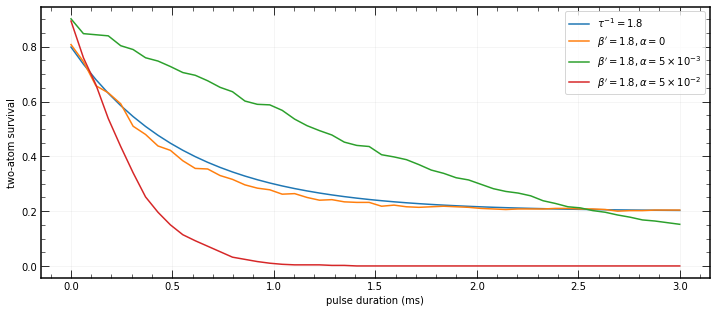

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
ts = np.linspace(1e-3, 3, 50)
beta_prime = 1.8
ax.plot(ts, .2+0.6*np.exp(-ts*beta_prime),label = r'$\tau^{-1}=1.8$')
plt.plot(ts, betaPrimeFit(ts,beta_prime,1e-4), label=r'$\beta^{\prime} = 1.8, \alpha = 0$')
plt.plot(ts, betaPrimeFit(ts,beta_prime,3e-3), label=r'$\beta^{\prime}  = 1.8, \alpha = 5\times 10^{-3}$')
plt.plot(ts, betaPrimeFit(ts,beta_prime,5e-3), label=r'$\beta^{\prime}  = 1.8, \alpha = 5\times 10^{-2}$')
plt.ylabel('two-atom survival')
plt.xlabel('pulse duration (ms)')
plt.legend();
# plt.ylim(0,1)

In [42]:
### beta prime evaluated multiple times at each time step for each trajectory

def betaPrimeFit2(ts, beta_prime,alpha, U=1e-3,T0=30e-6 ):
    trajectories = 700
    n_point_per_time = 50
    fin_surv=[]
    
    for t in ts:
        times_x= np.linspace(0, t, n_point_per_time)
        dt_step = times_x[1] - times_x[0]
        surv_sum_traj = np.zeros(len(times_x))

        for j in np.arange(trajectories):
            N0 = 2  # Initial number of atoms
            surv_dts = np.zeros(len(times_x))
            surv_dts[0] = N0

            for i in range(len(times_x)):
                if i == 0:
                    num_atoms_at_this_step = surv_dts[0]
                else:
                    num_atoms_at_this_step = surv_dts[i - 1]

                P_two_body_loss = dq_two_body(beta_prime, num_atoms_at_this_step, dt_step)
                P_one_body_loss = dq_one_body(gamma(dt_step,U,T0,alpha), num_atoms_at_this_step, dt_step)

                prob_no_loss = (1 - P_one_body_loss) * (1 - P_two_body_loss)
                prob_one_loss = P_one_body_loss * (1 - P_two_body_loss)
                prob_two_loss = (1 - P_one_body_loss) * P_two_body_loss

                prob_dict = {'no_loss': prob_no_loss, 'one_loss': prob_one_loss, 'two_loss': prob_two_loss}

                # Define a probability order
                ordered_dict = sorted(prob_dict.items(), key=lambda x: x[1])

                # Choose which decay channel will happen using Monte Carlo
                p_rand = random.random()
                p_rand_20_21 = random.random()
                if p_rand < ordered_dict[0][1]: # if random number is less than the smallest loss probability of the three loss options
                    if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                        surv_dts[i] -= 1
                    else: 
                        surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[0][0]) # then the # of remaining atoms at this time step is determined by key name of smallest survival probability
                    # print('key, atoms lost=',ordered_dict[0][0],',',number_of_lost_atoms(ordered_dict[0][0]))
                    # print('remaining atoms at this time=',surv_dts[i])
                elif ordered_dict[0][1] < p_rand < ordered_dict[1][1]: # if random number is between smallest loss and second smallest loss probability 
                    if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                        surv_dts[i] -= 1  
                    else:
                        surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[1][0])
                    # print('key, atoms lost=',ordered_dict[1][0],',',number_of_lost_atoms(ordered_dict[1][0]))
                    # print('remaining atoms at this time=',surv_dts[i])
                else: # if random number is greater than both of the 2 smallest probabilities
                    if surv_dts[i] == 2 and p_rand_20_21 < 0.2:
                        surv_dts[i] -= 1                
                    else:
                        surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[2][0]) # the # of atoms remaining = inital atom # - value for the key with the largest probability
                    # print('key, atoms lost=',ordered_dict[2][0],',',number_of_lost_atoms(ordered_dict[2][0]))
                    # print('remaining atoms at this time=',surv_dts[i])

            # apply a 2->1 collision (80% probability 2-1) and image (20% prob of 2-1)
            for k in range(len(surv_dts)):
                p_rand_LAC_21 = random.random()
                p_rand_image_21 = random.random()
                if surv_dts[k] == 2 and p_rand_LAC_21 <= .85: #2-1 pulse
                    surv_dts[k] -= 1   
                if surv_dts[k] == 2 and p_rand_image_21 <= 0.1: #imaging pulse
                    surv_dts[k] -= 1            
                if surv_dts[k] == 2:         
                    surv_dts[k] = 0

            surv_sum_traj += surv_dts
        surv_average = surv_sum_traj / trajectories
        fin_surv.append(surv_average[-1])
    return fin_surv 

## Brute force fitting

In [15]:
# Used for the fitting:
def residual(betaPrime,x_pts, data, uncertainties,alpha):
    model = betaPrimeFit(x_pts, betaPrime,alpha,U=1e-3,T0=30e-6)
    return (((model-data)/uncertainties)**2).sum()

In [9]:
def get_smoothed_residual_f(x, residual):
    _sg = savgol_filter(residual, window_length=7, polyorder=3) # window size 51, polynomial order 3
    _f = interp1d(x, _sg, kind='cubic')
    return _f

In [10]:
def get_minimum(_f, x0):
    _xmin,_fmin, _,_,warnflag = fmin(_f, 
        x0, disp=False,full_output=True)
    if warnflag:
        print(f"{warnflag:d} ---  1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.")
    return _xmin, _fmin

In [11]:
def get_root(_f, y0, xbound0, xbound1):
    _f_offset = lambda x : (_f(x) - y0)
    root = brentq(_f_offset, xbound0, xbound1, disp=False)
    return root
    # return get_minimum(_f=_f_offset, x0=x0)

In [65]:
x_data = np.linspace(0,3e-3,8)
y_data = decay_exponential(x_data,1, 1.8e3,0) 
errs = [0.1 for _ in range(8)]

mean_noise = 0.0  # Mean of the noise
std_dev_noise = 0.1  # Standard deviation of the noise
noise = np.random.normal(mean_noise, std_dev_noise, len(x_data))
y_data_with_noise = y_data + noise

surv = y_data
surv_unc = errs
x_axis = x_data
rranges = (slice(1e3, 3e3, 0.1e3),)

out, fout, grid, fgrid = optimize.brute(residual,rranges,
    args=(x_axis, surv, surv_unc),full_output=True,finish='leastsq')

Text(0, 0.5, 'survival')

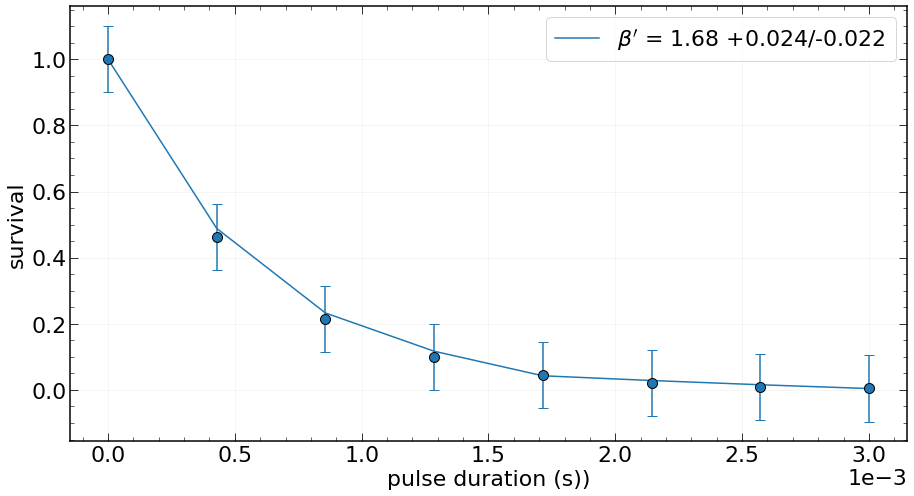

In [69]:
f_loss_smooth = get_smoothed_residual_f(grid, fgrid)
grid_min, loss_min = get_minimum(f_loss_smooth, out)
grid_min_err_low = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid.min(), xbound1=grid_min)
grid_min_err_high = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid_min, xbound1=grid.max())
low_err=grid_min[0]-grid_min_err_low # those turns out to be array with only one element
high_err=grid_min_err_high-grid_min[0]
popt_min=grid_min[0]
loss_mins=loss_min
# print(grid_min, grid_min_err_low, grid_min_err_high, loss_min)
fig,ax = plt.subplots(1, figsize=[15,8])

times= np.linspace(0, 3e-3, 50)
ax.plot(x_data, betaPrimeFit2(x_data,popt_min), 
        label= f"$\\beta'$ = {popt_min*1e-3:.2f} +{high_err*1e-3:.3f}/-{low_err*1e-3:.3f} ")
ax.errorbar(x_data,y_data, yerr=errs,ls='none',ecolor='tab:blue',marker = 'o',markersize = 10,markerfacecolor='tab:blue',markeredgecolor='k',capsize=5)
ax.plot(
ax.legend()
ax.set_xlabel(r"pulse duration (s))")
ax.set_ylabel("survival")

## beta prime fit

### test data

In [13]:
def decay_exponential(x, A, k, C):
    return A * np.exp(-k * x) + C


In [16]:
x_data = np.linspace(0,3e-3,30)
y_data = .2+.6*decay_exponential(x_data,1, 1.8e3,0)
errs = [0.1 for _ in range(30)]
alpha = 3e-4
mean_noise = 0.0  # Mean of the noise
std_dev_noise = 0.02  # Standard deviation of the noise

# Generate random noise
noise = np.random.normal(mean_noise, std_dev_noise, len(x_data))

# Add noise to the data
y_data_with_noise = y_data + noise

surv = y_data
surv_unc = errs
x_axis = x_data
rranges = (slice(1e3, 3e3, 0.1e3),)

out, fout, grid, fgrid = optimize.brute(residual,rranges,
    args=(x_axis, surv, surv_unc,alpha),full_output=True,finish='leastsq')

Text(0.5, 1.0, 'test data')

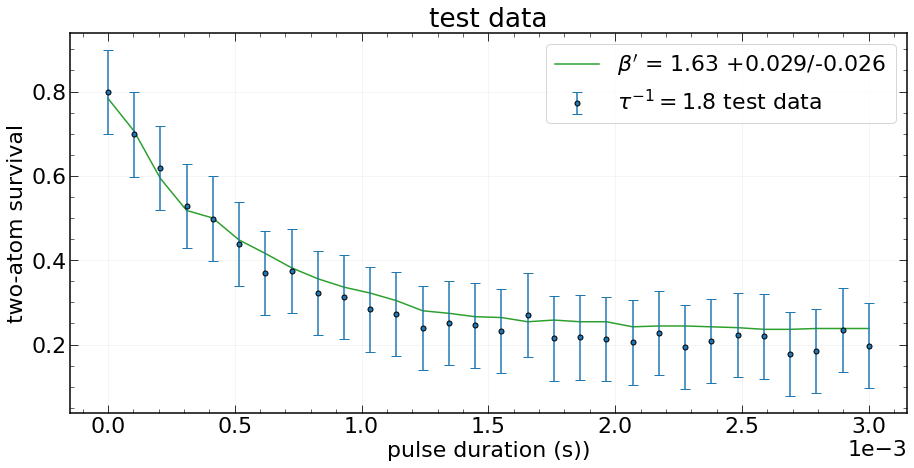

In [24]:
f_loss_smooth = get_smoothed_residual_f(grid, fgrid)
grid_min, loss_min = get_minimum(f_loss_smooth, out)
grid_min_err_low = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid.min(), xbound1=grid_min)
grid_min_err_high = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid_min, xbound1=grid.max())
low_err=grid_min[0]-grid_min_err_low # those turns out to be array with only one element
high_err=grid_min_err_high-grid_min[0]
popt_min=grid_min[0]
loss_mins=loss_min
# print(grid_min, grid_min_err_low, grid_min_err_high, loss_min)
fig,ax = plt.subplots(1, figsize=[15,7])

times= np.linspace(0, 3e-3, 50)
ax.plot(x_data, betaPrimeFit(x_data,popt_min,1e-4), 
        label= f"$\\beta^{{\\prime}}$ = {popt_min*1e-3:.2f} +{high_err*1e-3:.3f}/-{low_err*1e-3:.3f} ",color='tab:green')
ax.errorbar(x_data,y_data_with_noise, yerr=errs,ls='none',ecolor=color2,marker = 'o',markersize = 5,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize,label = r'$\tau^{-1}=1.8$ test data')
# ax.plot(x_data, y_data,color=color2,label=r'$\tau^{-1}=1.8$')

# alpha, decay_constant = ah.beta_fit_guess(x_data,load_one_y,load_two_y,load_one_err, 1e-3, 30e-6,alpha_guess=125e-6)
ax.legend()
ax.set_xlabel(r"pulse duration (s))")
ax.set_ylabel(r"two-atom survival")
ax.set_title("test data")

## real data

### define data fitting functions

In [27]:
def P_survival_lin_heating(t, alpha, U0, T0):
    tau = 5
    P_vacuum = np.exp(-t/tau)
    P_heat = 1- np.exp(- U0/(T0 + alpha*t) ) * ( 1+ U0/(T0 + alpha*t) + U0**2/(2*(T0 + alpha*t)**2) )
    return P_vacuum*P_heat

def linearHeatingFit(x_data,y_data,y_err,U0, T0,alpha_guess=135e-6,num_points=100,plot=True):
    y_data_lower_errors = y_err[0]  
    y_data_upper_errors = y_err[1]
    y_data_errors = np.mean([y_data_lower_errors, y_data_upper_errors], axis=0)
    initial_guesses = (alpha_guess,U0,T0)   # Initial guesses for the parameters
    params, covariance = curve_fit(P_survival_lin_heating, x_data, y_data, 
                                   p0=initial_guesses,sigma=y_data_errors, absolute_sigma=True) 
    optimal_alpha = params[0]
    alpha_error = np.sqrt(np.diag(covariance))[0]*1e-7
    fit_curve = P_survival_lin_heating(x_data, optimal_alpha,U0,T0)
    if plot:
        plt.plot(x_data, fit_curve, label=f'$\\alpha$ ={optimal_alpha:.2e} ± {alpha_error:.2e}')
    return optimal_alpha
    
def decay_exponential(x, A, k, C):
    return A * np.exp(-k * x) + C

def decay_fit(x_data,y_data,num_points=100,plot=True):
    initial_guess = [max(y_data), 0.1, min(y_data)]
    popt, pcov = curve_fit(decay_exponential, x_data, y_data, p0=initial_guess)
    x_fit = np.linspace(min(x_data), max(x_data), num_points)
    y_fit = decay_exponential(x_fit, *popt)
    decay_constant = popt[1]
    decay_constant_uncertainty = np.sqrt(pcov[1, 1])
    one_over_e_time = 1 / decay_constant
    one_over_e_time_uncertainty = decay_constant_uncertainty / decay_constant
    decay_constant_str = f"{decay_constant:.4f}"
    decay_constant_uncertainty_str = f"{decay_constant_uncertainty:.4f}"
    legend_label = f'$\\tau^{{-1}}$ = {decay_constant_str} ± {decay_constant_uncertainty_str}'
    if plot:
        plt.plot(x_fit, y_fit, color='tab:blue',label=legend_label)
    return decay_constant, x_fit, y_fit, decay_constant_uncertainty

def beta_fit_guess(x_data,load_one_y_data,load_two_y_data,load_one_y_err,U0, T0,alpha_guess=135e-6,num_points=100,plot=True):
    alpha = linearHeatingFit(x_data,load_one_y_data,load_one_y_err,U0, T0,alpha_guess,num_points,plot)
    decay_constant,x_fit,y_fit, unc = decay_fit(x_data,load_two_y_data,num_points,plot)
    return alpha, decay_constant

In [28]:
x_data = np.array([1.00000e-04, 6.00080e-01, 1.20006e+00, 1.80004e+00, 2.40002e+00,3.00000e+00])
load_one_y = np.array([0.99, 0.86486486, 0.76666667, 0.66176471, 0.50819672,0.46052632])
load_one_err = [[0.037332869102714605,0.04457423253875692,0.05867479320059943,0.0593463353540572,0.0636239699130931,0.05628870466424918],
 [0.02375240928466049,0.03478412349046234,0.04987096487917719,0.05462979075485197,0.06335785007267136,0.057319345688431556]]
load_two_y=np.array([0.8, 0.37974684, 0.23376623, 0.2, 0.18518519,0.16901408])
load_two_err = [[0.037332869102714605,0.04457423253875692,0.05867479320059943,0.0593463353540572,0.0636239699130931,0.05628870466424918],
 [0.02375240928466049,0.03478412349046234,0.04987096487917719,0.05462979075485197,0.06335785007267136,0.057319345688431556]]

In [29]:
num_points = 50 # number of points for exponential fit of data
surv_unc = np.mean([np.mean([up,lo]) for (up,lo) in zip(load_two_err[0],load_two_err[1])])
uncertainties = [surv_unc]*num_points
alpha, decay_constant = beta_fit_guess(x_data,load_one_y,load_two_y,load_one_err, 1e-3, 30e-6,alpha_guess=125e-6,num_points = num_points,plot=False)
_,x_fit,y_fit,unc = decay_fit(x_data,load_two_y,num_points = num_points,plot=False)
rranges = (slice((decay_constant-2), (decay_constant+2), 0.1),)
out, fout, grid, fgrid = optimize.brute(residual,rranges,
    args=(x_fit, y_fit, uncertainties,alpha),full_output=True,finish='leastsq')

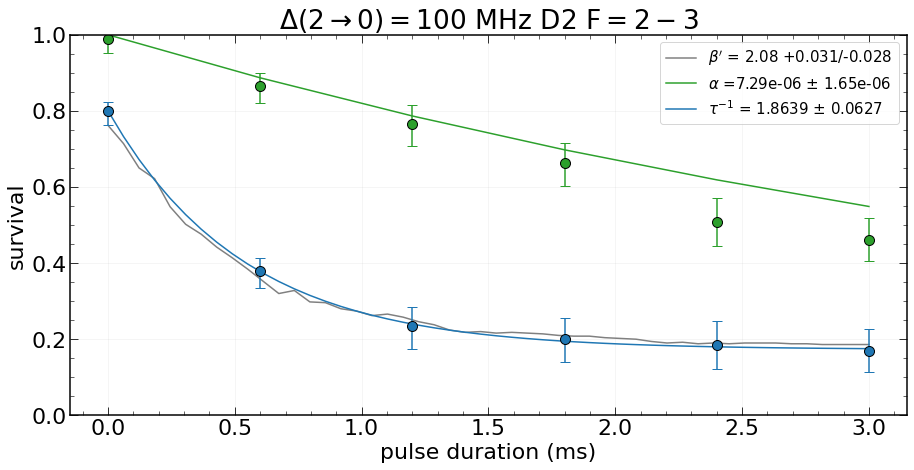

In [31]:
f_loss_smooth = get_smoothed_residual_f(grid, fgrid)
grid_min, loss_min = get_minimum(f_loss_smooth, out)
grid_min_err_low = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid.min(), xbound1=grid_min)
grid_min_err_high = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid_min, xbound1=grid.max())
low_err=grid_min[0]-grid_min_err_low # those turns out to be array with only one element
high_err=grid_min_err_high-grid_min[0]
popt_min=grid_min[0]
loss_mins=loss_min
# print(grid_min, grid_min_err_low, grid_min_err_high, loss_min)
fig,ax = plt.subplots(1, figsize=[15,7])

times= np.linspace(0, 3e-3, 50)
ax.plot(x_fit, betaPrimeFit(x_fit,popt_min,alpha), 
        label= f"$\\beta^{{\\prime}}$ = {popt_min:.2f} +{high_err:.3f}/-{low_err:.3f} ",color='grey')

ax.errorbar(x_data,load_two_y, yerr=load_two_err,ls='none',ecolor=color2,marker = 'o',markersize = markersize,
            markerfacecolor=color2,markeredgecolor='k',capsize=capsize)


ax.errorbar(x_data,load_one_y, yerr=load_one_err,ls='none',ecolor=color1,marker = 'o',markersize = markersize,
            markerfacecolor=color1,markeredgecolor='k',capsize=capsize)
alpha, decay_constant = beta_fit_guess(x_data,load_one_y,load_two_y,load_one_err, 1e-3, 30e-6,alpha_guess=125e-6,num_points = num_points,plot=True)

ticks = np.arange(x_data[0], max(x_data),len(x_data))
plt.legend(loc= 'upper right', ncol = 1,prop={'size': 15})
plt.ylim(0,1)
plt.ylabel('survival')
plt.xlabel(r'pulse duration (ms)')
plt.title(r'$ \Delta(2 \rightarrow 0) = 100 \ \mathrm{MHz} \ \mathrm{D2 \ F=2-3} $');
